In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from skimage.transform import resize
import pickle
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load the datasets 
train_data = pd.read_csv('/content/drive/MyDrive/report_Gen_model/train-test-cv_split/train.csv')
val_data = pd.read_csv('/content/drive/MyDrive/report_Gen_model/train-test-cv_split/val.csv')
test_data = pd.read_csv('/content/drive/MyDrive/report_Gen_model/train-test-cv_split/test.csv')

# Check the data
print("Train Data Shape:", train_data.shape)
print("Validation Data Shape:", val_data.shape)
print("Test Data Shape:", test_data.shape)
train_data.head()


Train Data Shape: (2335, 4)
Validation Data Shape: (501, 4)
Test Data Shape: (501, 4)


,Person_id,Image1,Image2,Report
0,3691,3691_IM-1842-1001.dcm.png,3691_IM-1842-3003.dcm.png,startseq heart normal size. mediastinum stable...
1,3071,3071_IM-1433-1001.dcm.png,3071_IM-1433-2001.dcm.png,startseq heart size normal. lungs clear. no fo...
2,3496,3496_IM-1701-2001.dcm.png,3496_IM-1701-2001.dcm.png,startseq heart size normal. mediastinal contou...
3,3190,3190_IM-1505-1001.dcm.png,3190_IM-1505-2001.dcm.png,startseq eamination consists frontal lateral r...
4,3951,3951_IM-2019-1001.dcm.png,3951_IM-2019-2001.dcm.png,startseq cardiomediastinal silhouette normal s...


In [4]:
# Load DenseNet model without the final classification layer
chexNet = densenet.DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3), pooling="avg")

# Add custom output layer for feature extraction
X = chexNet.output
X = tf.keras.layers.Dense(14, activation="sigmoid", name="predictions")(X)
model = tf.keras.Model(inputs=chexNet.input, outputs=X)

# Load pre-trained weights for CheXNet
model.load_weights('/content/drive/MyDrive/report_Gen_model/CheXNet_Keras_weights.h5')

# Feature extractor model
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
feature_extractor.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

verf. of features

In [ ]:
import pickle
import numpy as np

# File paths
features_file = '/content/drive/MyDrive/report_Gen_model/all_features2.pickle'  
train_csv = '/content/drive/MyDrive/report_Gen_model/train-test-cv_split/train.csv'  
val_csv = '/content/drive/MyDrive/report_Gen_model/train-test-cv_split/val.csv'      
test_csv = '/content/drive/MyDrive/report_Gen_model/train-test-cv_split/test.csv'    

# Load the datasets
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Load the extracted features
with open(features_file, 'rb') as f:
    all_features = pickle.load(f)

# Quality checks
def check_features():
    results = {}
    for dataset_name, data, csv_data in zip(
        ['train', 'val', 'test'],
        [all_features['train'], all_features['val'], all_features['test']],
        [train_data, val_data, test_data]
    ):
        print(f"\n--- Checking {dataset_name} dataset ---")

        # Check the number of keys
        num_keys = len(data)
        expected_samples = len(csv_data)
        print(f"Number of keys: {num_keys}, Expected: {expected_samples}")
        if num_keys != expected_samples:
            print(f"WARNING: Mismatch in number of keys for {dataset_name}!")

        # Check the feature vector shape
        if num_keys > 0:
            key_to_check = list(data.keys())[0]
            feature_shape = data[key_to_check].shape
            print(f"Feature vector shape for key '{key_to_check}': {feature_shape}")
            if feature_shape != (1, 2048):
                print(f"WARNING: Feature vector shape is incorrect for {dataset_name}!")

            # Check feature vector values
            feature_values = data[key_to_check]
            if np.all(feature_values == 0):
                print(f"WARNING: All feature values are zero for key '{key_to_check}'!")
            elif np.isnan(feature_values).any():
                print(f"WARNING: Feature values contain NaN for key '{key_to_check}'!")
            else:
                print(f"Feature values look normal for key '{key_to_check}'.")

        else:
            print(f"WARNING: {dataset_name} dataset is empty!")

    return results

# Run checks
check_features()



--- Checking train dataset ---
Number of keys: 2335, Expected: 2335
Feature vector shape for key '3691': (1, 2048)
Feature values look normal for key '3691'.

--- Checking val dataset ---
Number of keys: 501, Expected: 501
Feature vector shape for key '2235': (1, 2048)
Feature values look normal for key '2235'.

--- Checking test dataset ---
Number of keys: 501, Expected: 501
Feature vector shape for key '3184': (1, 2048)
Feature values look normal for key '3184'.


{}

In [ ]:
# Segregate the dataset into inputs (features) and outputs (reports)
X_train = train_data['Person_id']
X_test = test_data['Person_id']
X_val = val_data['Person_id']

y_train = train_data['Report']
y_test = test_data['Report']
y_val = val_data['Report']

print(f"Training Set - X: {len(X_train)}, y: {len(y_train)}")
print(f"Validation Set - X: {len(X_val)}, y: {len(y_val)}")
print(f"Test Set - X: {len(X_test)}, y: {len(y_test)}")


Training Set - X: 2335, y: 2335
Validation Set - X: 501, y: 501
Test Set - X: 501, y: 501


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize and fit the tokenizer on the training set reports
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

print(f"Vocabulary Size: {len(tokenizer.word_index)}")
print(f"Example Tokenized Report: {tokenizer.texts_to_sequences([y_train.values[0]])}")

Vocabulary Size: 1753
Example Tokenized Report: [[2, 6, 5, 47, 30, 97, 134, 200, 91, 67, 1, 8, 26, 4, 13, 15, 36, 31, 32, 106, 72, 3]]


In [ ]:
# Define maximum sequence length for padding
padding_size = 153  # Maximum report length
vocab_size = len(tokenizer.word_index.keys()) + 1  # Add 1 for padding token

print(f"Padding Size: {padding_size}, Vocabulary Size: {vocab_size}")

Padding Size: 153, Vocabulary Size: 1754


In [ ]:
import pickle

# Load GloVe vectors
with open(r"/content/drive/MyDrive/report_Gen_model/glove_vectors300d.pickle", 'rb') as f:
    glove_vectors = pickle.load(f)

print(f"Sample GloVe Vector for 'lungs': {glove_vectors.get('lungs', 'Not found')}")


Sample GloVe Vector for 'lungs': [-0.18481, 0.11863, -0.16665, 0.0035226, 0.39392, 0.34791, 0.23127, 0.1021, -0.19905, -0.94654, -0.58303, -0.68176, -0.54091, 0.038454, -0.285, 0.84757, -0.56302, -0.063912, -0.21158, 0.62238, -0.1685, 0.3125, -0.34219, 0.17724, -0.44635, -0.19539, 0.40748, -0.26759, -0.09085, -0.51311, -0.36581, 0.84596, -0.30036, 0.43592, 0.3092, 0.099434, -0.16415, 0.011831, 0.13877, 0.75933, -0.52078, 0.064324, -0.24257, -0.037112, 0.23374, 0.1588, 0.16659, 0.51749, -0.22648, -0.13326, 0.13009, -0.29105, 0.14483, -0.1521, -0.48618, 0.46953, 0.51945, -0.42349, 0.021929, 0.47076, -0.2362, 0.24464, 0.22494, 0.22861, -0.17532, -0.018645, 0.53344, -0.090447, 0.0057687, 0.56548, 0.74515, -0.53951, 0.6373, 0.69086, 0.49853, -0.79388, -0.25584, -0.46874, -0.15393, -0.091604, -0.15018, -0.24776, 0.26943, -0.55744, -0.58235, 0.45097, 0.21834, -0.38322, -0.51351, 0.1574, 0.015948, 0.12866, -0.28619, 0.23484, 0.14937, 0.29989, -0.32139, 0.22716, 0.60871, 0.26331, 0.28153, -0.46

In [10]:
import numpy as np

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))  # 300 dimensions from GloVe

# Populate embedding matrix with GloVe vectors
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

# Verification code
print(f"Shape of Embedding Matrix: {embedding_matrix.shape}")
print(f"Sample Embedding Vector: {embedding_matrix[tokenizer.word_index['lungs']]}")


Shape of Embedding Matrix: (1754, 300)
Sample Embedding Vector: [-1.8481e-01  1.1863e-01 -1.6665e-01  3.5226e-03  3.9392e-01  3.4791e-01
  2.3127e-01  1.0210e-01 -1.9905e-01 -9.4654e-01 -5.8303e-01 -6.8176e-01
 -5.4091e-01  3.8454e-02 -2.8500e-01  8.4757e-01 -5.6302e-01 -6.3912e-02
 -2.1158e-01  6.2238e-01 -1.6850e-01  3.1250e-01 -3.4219e-01  1.7724e-01
 -4.4635e-01 -1.9539e-01  4.0748e-01 -2.6759e-01 -9.0850e-02 -5.1311e-01
 -3.6581e-01  8.4596e-01 -3.0036e-01  4.3592e-01  3.0920e-01  9.9434e-02
 -1.6415e-01  1.1831e-02  1.3877e-01  7.5933e-01 -5.2078e-01  6.4324e-02
 -2.4257e-01 -3.7112e-02  2.3374e-01  1.5880e-01  1.6659e-01  5.1749e-01
 -2.2648e-01 -1.3326e-01  1.3009e-01 -2.9105e-01  1.4483e-01 -1.5210e-01
 -4.8618e-01  4.6953e-01  5.1945e-01 -4.2349e-01  2.1929e-02  4.7076e-01
 -2.3620e-01  2.4464e-01  2.2494e-01  2.2861e-01 -1.7532e-01 -1.8645e-02
  5.3344e-01 -9.0447e-02  5.7687e-03  5.6548e-01  7.4515e-01 -5.3951e-01
  6.3730e-01  6.9086e-01  4.9853e-01 -7.9388e-01 -2.5584e-01

In [12]:
# Define the batch size
BATCH_SIZE = 2 

In [13]:
# Load the extracted features from the pickle file
with open("/content/drive/MyDrive/report_Gen_model/all_features2.pickle", 'rb') as f:
    cheXnet_Features = pickle.load(f)


In [14]:
def load_image(id_, report, dataset_name="train"):
    """
    Loads the Image Features with their corresponding IDs from cheXnet_Features.
    """
    id_int = int(id_)  # Ensure ID is an integer
    img_feature = cheXnet_Features[dataset_name].get(id_int, None)  # Use dataset_name to access the correct subset
    if img_feature is None:
        print(f"Warning: No feature found for ID: {id_int} in {dataset_name} dataset. Skipping...")
        return None, None  # Return None for missing features
    return img_feature[0], report


verif.

In [15]:
# Function to test load_image exhaustively
def test_load_image():
    # Sample multiple IDs from train_data
    print("\n--- Verifying load_image Function ---")
    for idx in range(5):  # Testing first 5 IDs for brevity
        sample_id = str(train_data['Person_id'].iloc[idx])  # Ensure the ID is treated as a string
        sample_report = train_data['Report'].iloc[idx]
        print(f"\nTesting ID: {sample_id}, Report: {sample_report[:50]}...")

        # Try loading the feature
        try:
            sample_feature, sample_report_returned = load_image(sample_id, sample_report)
            print(f"Feature Shape: {sample_feature.shape}")
            print(f"Report Match: {sample_report == sample_report_returned}")
        except ValueError as e:
            print(f"Error: {e}")

    # Test for a missing ID
    print("\nTesting for Missing ID...")
    try:
        invalid_id = "9999999"  # Non-existent ID
        load_image(invalid_id, "Test Report")
    except ValueError as e:
        print(f"Handled Missing ID Correctly: {e}")

    # Test for an unexpected ID type
    print("\nTesting for Unexpected ID Type...")
    try:
        invalid_type_id = 123.456  # Float instead of string/int
        load_image(invalid_type_id, "Test Report")
    except Exception as e:
        print(f"Handled Unexpected ID Type: {e}")

# Run the test
test_load_image()



--- Verifying load_image Function ---

Testing ID: 3691, Report: startseq heart normal size. mediastinum stable. at...
Feature Shape: (2048,)
Report Match: True

Testing ID: 3071, Report: startseq heart size normal. lungs clear. no focal ...
Feature Shape: (2048,)
Report Match: True

Testing ID: 3496, Report: startseq heart size normal. mediastinal contour wi...
Feature Shape: (2048,)
Report Match: True

Testing ID: 3190, Report: startseq eamination consists frontal lateral radio...
Feature Shape: (2048,)
Report Match: True

Testing ID: 3951, Report: startseq cardiomediastinal silhouette normal size ...
Feature Shape: (2048,)
Report Match: True

Testing for Missing ID...

Testing for Unexpected ID Type...


In [16]:
def dataset_generator(img_name, caption, dataset_name):
    """
    Creates a TensorFlow dataset generator that pairs image features with corresponding captions.
    """

    def map_function(item1, item2):
        # Load features and filter out None values
        img_feature, report = load_image(item1, item2, dataset_name)
        if img_feature is None:  # Skip missing features
            return tf.constant([], dtype=tf.float32), tf.constant("", dtype=tf.string)
        return img_feature, report

    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(
        lambda item1, item2: tf.numpy_function(map_function, [item1, item2], [tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    # Filter out invalid (empty) entries
    dataset = dataset.filter(lambda x, y: tf.not_equal(tf.size(x), 0))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(100).batch(BATCH_SIZE).prefetch(buffer_size=2)
    return dataset


In [17]:
def verify_generator(generator, dataset_name, num_samples=3):
    """
    Verifies the dataset generator by printing feature shapes and corresponding reports.
    """
    print(f"\n--- Verifying {dataset_name} Generator ---")
    for batch_num, (features, reports) in enumerate(generator.take(num_samples)):
        print(f"Batch {batch_num + 1}:")
        print(f" - Feature Shape: {features.shape}")
        print(f" - Sample Report: {reports.numpy()[0].decode('utf-8')}")
    print(f"{dataset_name} generator verification completed.")


In [18]:
# Re-generate datasets
train_generator = dataset_generator(train_data['Person_id'].values, train_data['Report'].values, "train")
val_generator = dataset_generator(val_data['Person_id'].values, val_data['Report'].values, "val")
test_generator = dataset_generator(test_data['Person_id'].values, test_data['Report'].values, "test")

# Verify each generator
verify_generator(train_generator, "train")
verify_generator(val_generator, "validation")
verify_generator(test_generator, "test")



--- Verifying train Generator ---
Batch 1:
 - Feature Shape: (2, 2048)
 - Sample Report: startseq cardiac mediastinal contours within normal limits. lungs clear. bony structures intact. endseq
Batch 2:
 - Feature Shape: (2, 2048)
 - Sample Report: startseq mediastinal contours normal. lungs clear. no pneumothora large pleural effusion. endseq
Batch 3:
 - Feature Shape: (2, 2048)
 - Sample Report: startseq normal heart size. stable position pacemaker electrodes tip epected region right atrium another tip epected region right ventricle. no pulmonary edema. no focal consolidation. no pleural effusion. no evidence pneumothora. unremarkable. endseq
train generator verification completed.

--- Verifying validation Generator ---
Batch 1:
 - Feature Shape: (2, 2048)
 - Sample Report: startseq postsurgical postradiation changes left lung spiculated hyperdense scar left upper thora. loss lung volume left due postsurgical change. deviation towards left. right lung hyperepanded. right lung clear.

In [19]:
def bytes_to_string(arr):

    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')  # Decode bytes to string
    return arr


In [20]:
def convert(images, reports):
    """
    Converts batches of images and reports into training-ready format:
    - Images remain as features.
    - Reports are split into input and output sequences for the model.
    """
    imgs = []
    in_reports = []
    out_reports = []

    for i in range(len(images)):
        # Convert report text into a sequence of tokens
        sequence = [tokenizer.word_index.get(word, 0) for word in reports[i].split()]

        # Generate input-output pairs for the model
        for j in range(1, len(sequence)):
            in_seq = sequence[:j]  # Input: partial sequence
            out_seq = sequence[j]  # Output: next word

            # One-hot encode the output word
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            # Append to lists
            imgs.append(images[i])           # Corresponding image feature
            in_reports.append(in_seq)        # Input text sequence
            out_reports.append(out_seq)      # One-hot encoded next word

    # Pad input sequences to have uniform length
    in_reports_padded = tf.keras.preprocessing.sequence.pad_sequences(in_reports, maxlen=padding_size, padding='post')

    return np.array(imgs), np.array(in_reports_padded), np.array(out_reports)


In [ ]:
# Take a sample batch from the train_generator
for img_batch, report_batch in train_generator.take(1):
    # Decode byte reports back to text
    decoded_reports = bytes_to_string(report_batch.numpy())

    # Convert the batch into input-output pairs for training
    imgs, in_reports, out_reports = convert(img_batch.numpy(), decoded_reports)

    # Verification Outputs
    print(f"Image Batch Shape: {imgs.shape}")
    print(f"Input Reports Shape: {in_reports.shape}")
    print(f"Output Reports Shape (One-Hot): {out_reports.shape}")

    # Show a sample report with input-output pairs
    print(f"\nSample Decoded Report:\n{decoded_reports[0]}")
    print(f"\nSample Input Sequence:\n{in_reports[0]}")
    print(f"\nSample Output Word (One-Hot):\n{out_reports[0]}")

    # Verify the One-Hot Vector
    print(f"\nSum of One-Hot Vector (should be 1): {np.sum(out_reports[0])}")
    print(f"Index of '1' in One-Hot Vector: {np.argmax(out_reports[0])}")


🖼️ Image Batch Shape: (42, 2048)
📝 Input Reports Shape: (42, 153)
🔠 Output Reports Shape (One-Hot): (42, 1754)

📄 Sample Decoded Report:
startseq heart size mediastinal contours appear within normal limits. pulmonary vascularity within normal limits. no focal consolidation suspicious pulmonary opacity pneumothora definite pleural effusion. visualized osseous structures appear intact. endseq

🔢 Sample Input Sequence:
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]

🎯 Sample Output Word (One-Hot):
[0. 0. 0. ... 0. 0. 0.]

✅ Sum of One-Hot Vector (should be 1): 1.0
🎯 Index of '1' in One-Hot Vector: 6


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add

# Encoder
input1 = Input(shape=(2048,), name='Image_input')
dense1 = Dense(256, activation='relu', name='dense_encoder')(input1)

# Decoder
input2 = Input(shape=(153,), name='Text_Input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, input_length=153,
                            weights=[embedding_matrix], mask_zero=True, trainable=False, name="Embedding_layer")
emb = embedding_layer(input2)

# LSTM layers optimized for cuDNN
LSTM1 = LSTM(256,
             return_sequences=True,
             activation='tanh',          # Default (compatible with cuDNN)
             recurrent_activation='sigmoid',  # Default (compatible with cuDNN)
             use_bias=True,              # Default (compatible with cuDNN)
             name="LSTM1")(emb)

LSTM2 = LSTM(256,
             activation='tanh',          # Default (compatible with cuDNN)
             recurrent_activation='sigmoid',  # Default (compatible with cuDNN)
             use_bias=True,              # Default (compatible with cuDNN)
             name="LSTM2")(LSTM1)

dropout1 = Dropout(0.5)(LSTM2)
merged = Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', name='fc1')(merged)
dropout2 = Dropout(0.4)(fc1)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')(dropout2)

# Final Encoder-Decoder Model
encoder_decoder = Model(inputs=[input1, input2], outputs=output_layer)
encoder_decoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Text_Input (InputLayer)   │ (None, 153)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding_layer           │ (None, 153, 300)       │        526,200 │ Text_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 153)            │              0 │ Text_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM1 (LSTM)              │ (None, 153, 256)       │        570,368 │ Embedding_layer[0][0], │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM2 (LSTM)              │ (None, 256)            │        525,312 │ LSTM1[0][0],           │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_encoder (Dense)     │ (None, 256)            │        524,544 │ Image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ LSTM2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_encoder[0][0],   │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc1 (Dense)               │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ fc1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_layer (Dense)      │ (None, 1754)           │        450,778 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,662,994 (10.16 MB)

 Trainable params: 2,136,794 (8.15 MB)

 Non-trainable params: 526,200 (2.01 MB)

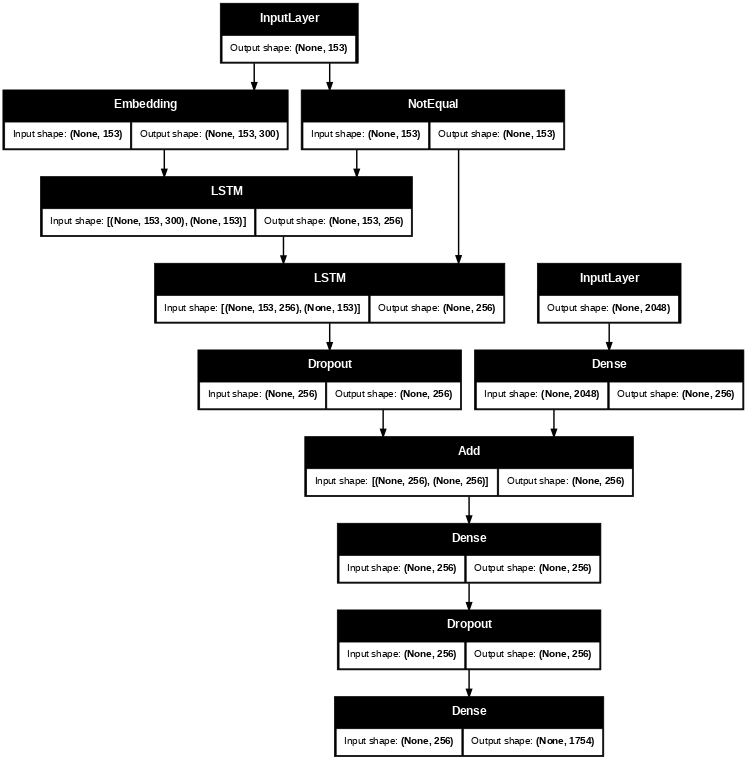

In [23]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True, dpi = 52)

In [24]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')

def maskedLoss(y_true, y_pred):
    # Mask the padding (value 0)
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    # Calculate the standard categorical crossentropy loss
    loss_ = loss_function(y_true, y_pred)

    # Apply the mask to ignore padding
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
optimizer = Adam(learning_rate=0.001)
encoder_decoder.compile(optimizer=optimizer, loss=maskedLoss)

print("Model compiled successfully with Adam optimizer and masked loss.")


✅ Model compiled successfully with Adam optimizer and masked loss.


In [ ]:
import psutil
import os

def memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 3)  # Convert bytes to GB
    print(f"Current RAM Usage: {mem:.2f} GB")

# Call this in your training loop
memory_usage()


💾 Current RAM Usage: 5.90 GB


In [35]:
model_save_path = r"encoder_decoder_model.h5"
encoder_decoder.save(model_save_path)

In [42]:
from tensorflow.keras.layers import LSTM

# Redefine LSTM to handle unrecognized arguments
class FixedLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop('time_major', None)  # Remove the unrecognized argument
        super(FixedLSTM, self).__init__(*args, **kwargs)


In [ ]:
from tensorflow.keras.models import load_model

# Path to the encoder-decoder model
model_path = "/content/drive/MyDrive/report_Gen_model/encoder_decoder_model.h5"  # Update this path!

# Load the model with the FixedLSTM
encoder_decoder = load_model(
    model_path,
    custom_objects={
        'maskedLoss': maskedLoss,
        'LSTM': FixedLSTM  # Use the fixed LSTM class
    }
)
# Explicitly load the weights from the last epoch
model_weights_path = "/content/drive/MyDrive/report_Gen_model/encoder_decoder_epoch_1 (1).h5"  # Replace with the actual path
encoder_decoder.load_weights(model_weights_path)
print("Model weights loaded successfully.")


# Check the model summary
encoder_decoder.summary()


✅ Model weights loaded successfully.


Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Text_Input (InputLayer)   │ (None, 153)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding_layer           │ (None, 153, 300)       │        526,200 │ Text_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 153)            │              0 │ Text_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM1 (FixedLSTM)         │ (None, 153, 256)       │        570,368 │ Embedding_layer[0][0], │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM2 (FixedLSTM)         │ (None, 256)            │        525,312 │ LSTM1[0][0],           │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_encoder (Dense)     │ (None, 256)            │        524,544 │ Image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ LSTM2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_encoder[0][0],   │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc1 (Dense)               │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ fc1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_layer (Dense)      │ (None, 1754)           │        450,778 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,662,996 (10.16 MB)

 Trainable params: 2,136,794 (8.15 MB)

 Non-trainable params: 526,200 (2.01 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Specify the path to the weights file saved during training
model_weights_path = "/content/drive/MyDrive/report_Gen_model/encoder_decoder_epoch_1 (1).h5"  

✅ Model weights loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
 Image processed successfully! Feature vector shape: (1, 2048)


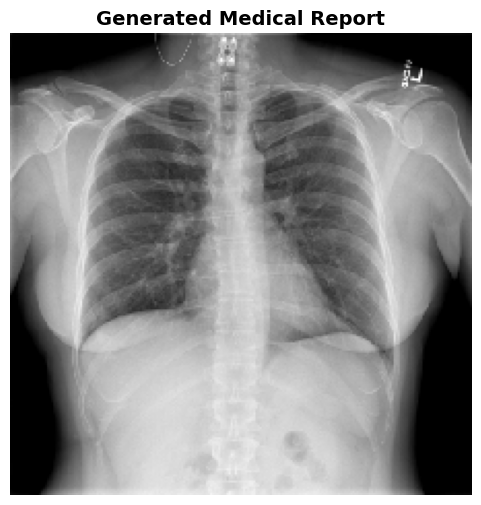


 Generated Medical Report:
no focal consolidation effusion pneumothora. pneumothoraces. pleural effusion pneumothora. pneumothora. osseous structures appear intact. no evidence pneumothora. pleural effusion pneumothora. focal focal airspace consolidation. pneumothoraces. heart size within normal limits. osseous structures intact. no pneumothora. pneumothora. effusions. pleural effusions. pneumothora. pneumothora. identified. no pneumothora. effusions. pneumothoraces. mild degenerative changes thoracic spine. pneumothoraces. mild evidence evidence evidence evidence evidence evidence evidence evidence focal pneumothora no pneumothora. effusion identified. visualized osseous structures abnormalities. no displaced fracture pneumothora. no pneumothora. abnormalities. pleural effusion seen. pneumothora seen. seen. no focal pneumothora. seen. pneumothoraces. mild evidence evidence evidence evidence evidence evidence pneumothora. pneumothora. effusions. pneumothora. pneumothora. pneumothora. 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from PIL import Image

#  Load Feature Extractor (Same as Training)
chexNet = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling="avg")
feature_extractor = Model(inputs=chexNet.input, outputs=chexNet.output)

#  Preprocess External Image & Handle 1024 → 2048 Issue
def preprocess_external_image(img_path):
    """Preprocess an external X-ray image to extract its feature vector and duplicate it for 2048 input."""
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize for DenseNet

    # Extract features
    img_features = feature_extractor.predict(img_array)
    img_features = np.squeeze(img_features)  

    #  Duplicate and Concatenate to match 2048
    img_features = np.concatenate((img_features, img_features), axis=0)  # Duplicate
    img_features = img_features.reshape(1, 2048)  # Ensure correct shape

    return img_features, img  # Return both feature vector and image for display

external_img_path = "/content/drive/MyDrive/report_Gen_model/images/CXR3_IM-1384-1001.png"

image_feature_vector, img_display = preprocess_external_image(external_img_path)
print(f" Image processed successfully! Feature vector shape: {image_feature_vector.shape}")  # Should be (1, 2048)

#  Generate Report for External Image
def generate_report(image_feature_vector, max_length=153):
    """Generate a medical report from an input image feature vector."""

    input_sequence = np.zeros((1, max_length))  # Initialize with zeros
    input_sequence[0, 0] = tokenizer.word_index.get('startseq', 1)  # Start token

    predicted_sequence = []

    for i in range(1, max_length):
        predictions = encoder_decoder.predict([image_feature_vector, input_sequence], verbose=0)
        next_word = np.argmax(predictions[0])  # Get most probable word index
        predicted_sequence.append(next_word)

        input_sequence[0, i] = next_word  # Update input sequence

        if next_word == tokenizer.word_index.get('endseq', 2):
            break  # Stop at end token

    # Convert sequence to text
    predicted_report = " ".join([reverse_word_index.get(idx, "<UNK>") for idx in predicted_sequence])

    return predicted_report

# Generate report for the external image
predicted_report = generate_report(image_feature_vector)


#  Display Image & Generated Report
plt.figure(figsize=(6,6))
plt.imshow(img_display)
plt.axis('off')
plt.title("Generated Medical Report", fontsize=14, weight='bold')
plt.show()

print("\n Generated Medical Report:")
print(predicted_report)

In [ ]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm  


#  Load Test Data
test_csv_path = "/content/drive/MyDrive/report_Gen_model/train-test-cv_split/test.csv"
features_file = "/content/drive/MyDrive/report_Gen_model/test_features.pickle"

# Load test CSV
test_data = pd.read_csv(test_csv_path)

# Load extracted test set features
with open(features_file, 'rb') as f:
    test_features = pickle.load(f)

# Ensure Person_id is a string in both test_data and feature dictionary
test_data['Person_id'] = test_data['Person_id'].astype(str).str.strip()
test_features = {str(key): value for key, value in test_features.items()}  # Ensure string keys

# Prepare test image features and corresponding reports
test_images = []
test_reports = []

for _, row in test_data.iterrows():
    person_id = row['Person_id']
    if person_id in test_features:
        test_images.append(test_features[person_id])  # Add features (already 2048-dim)
        test_reports.append(row['Report'])

# Convert to NumPy arrays
test_images = np.array(test_images)
test_reports = np.array(test_reports)

print(f"Test data loaded successfully! {len(test_images)} samples found.")


# Generate Reports for Test Set
def generate_report(image_feature_vector, max_length=153):
    """Generate a medical report from an input image feature vector."""

    input_sequence = np.zeros((1, max_length))  # Initialize with zeros
    input_sequence[0, 0] = tokenizer.word_index.get('startseq', 1)  # Start token

    predicted_sequence = []

    for i in range(1, max_length):
        predictions = encoder_decoder.predict([image_feature_vector, input_sequence], verbose=0)
        next_word = np.argmax(predictions[0])
        predicted_sequence.append(next_word)

        input_sequence[0, i] = next_word

        if next_word == tokenizer.word_index.get('endseq', 2):
            break

    # Convert sequence to text
    predicted_report = " ".join([reverse_word_index.get(idx, "<UNK>") for idx in predicted_sequence])

    return predicted_report


#  Compute Evaluation Metrics
total_bleu_score = 0
num_samples = len(test_images)

smoothing = SmoothingFunction().method1

# Add progress bar using tqdm
for idx, image_feature in tqdm(enumerate(test_images), total=num_samples, desc="Evaluating Test Set", ncols=100):
    image_feature = np.squeeze(image_feature).reshape(1, 2048)
    predicted_report = generate_report(image_feature)
    actual_report = test_reports[idx]

    # Compute BLEU Score
    actual_tokens = actual_report.lower().split()
    predicted_tokens = predicted_report.lower().split()
    bleu_score = sentence_bleu([actual_tokens], predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    total_bleu_score += bleu_score

# Compute average BLEU Score
average_bleu = total_bleu_score / num_samples
print(f"\n Average BLEU Score on Test Set: {average_bleu:.4f}")


✅ Test data loaded successfully! 501 samples found.


Evaluating Test Set: 100%|████████████████████████████████████████| 501/501 [29:53<00:00,  3.58s/it]


 Average BLEU Score on Test Set: 0.0331
